In [70]:
import random
random.seed(123)
import scipy.stats as stats
import numpy as np
import math
from scipy.stats import norm
from scipy.stats import gamma

true_beta = stats.norm.rvs(loc=0,scale=1,size=1)
true_phi = stats.gamma.rvs(a=3,scale=1/2,size=1)

x = stats.norm.rvs(loc=0,scale=1,size=100)
y=np.random.normal(x*true_beta, true_phi)

beta0 = stats.norm.rvs(loc=0,scale=1,size=1)
phi0 = stats.gamma.rvs(a=3,scale=1/2,size=1)
theta0 = np.hstack([beta0, phi0])

#Set hyperparameters
a = 3.0
b= 2.0

print(true_beta,true_phi)
print(theta0)

[-0.33083976] [ 2.00069499]
[ 1.89266561  0.60959579]


In [71]:
import warnings
warnings.filterwarnings("ignore")

In [72]:
def leapfrog(theta, r, eps):
    n = y.shape[0]
    gradients = np.array(theta[1]*(sum(x*y)-theta[0]*sum(x*x))-theta[0],((.5*n+a-1)/theta[1])-b-.5*sum((y-x*theta[0])*(y-x*theta[0])))
    r_upd = r + eps/2 * (gradients)
    theta_upd = theta + eps * r_upd
    r_upd = r_upd + eps/2 * (gradients)
    return theta_upd, r_upd

def log_joint(y, x, theta): 
    n = y.shape[0]
    return sum(norm.logpdf(y,loc=theta[0]*x, scale=theta[1]))+norm.logpdf(theta[0],loc=0,scale=1)+gamma.logpdf(theta[1],a,scale=1/b)
    

def hamilt_mc(theta0, y,x, eps, L, M):
    theta_m = np.zeros((M,2))
    theta_m[0,:] = theta0
    accept_b = 0
    accept_p = 0
    for m in range(1,M):
        r0 = stats.norm.rvs(size=2)
        theta_m[m,:] = theta_m[m-1,:]
        theta_tilde = theta_m[m-1,:]
        r_tilde = r0
        for i in range(L):
            theta_tilde, r_tilde = leapfrog(theta_tilde, r_tilde, eps) 
        if theta_tilde[1] < 0.0:
            #print("reject")
            theta_tilde[1] = theta_m[m-1,1]
            accept_p -=1
        alpha = min(1, np.exp(log_joint(y,x,theta_tilde)-(1/2)*r_tilde.dot(r_tilde))/np.exp(log_joint(y,x,theta_m[m-1,:])-1/2*r0.dot(r0)))
        u = np.random.uniform()
        if alpha > u:
            theta_m[m,:] = theta_tilde
            r_m = - r_tilde #confused why you save this each time since the algorithm has you repropose an r0 each iteration
            accept_b +=1
            accept_p +=1
    return(theta_m, accept_b, accept_p)

In [97]:
M = 50000
eps = .01
L= 5


In [98]:
%%time
results,accept1,accept2 = hamilt_mc(theta0, y,x, eps, L,M)
print("truth", (true_beta, true_phi))
beta_found = np.mean(results[round(4*M/5):(M-1),0])
phi_found = np.mean(results[round(4*M/5):(M-1),1])
print("Mean after burn in we find",beta_found ,phi_found)
print("Acceptance",accept1/M,accept2/M)

truth (array([-0.33083976]), array([ 2.00069499]))
Mean after burn in we find -0.189232173949 1.8923403607
Acceptance 0.311 0.31054
CPU times: user 46.3 s, sys: 135 ms, total: 46.5 s
Wall time: 46.5 s


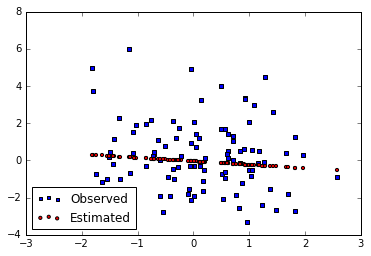

In [99]:
import matplotlib.pyplot as plt
%matplotlib inline

#y_sim = stats.norm.rvs(loc=x*beta_found,scale=1/np.sqrt(phi_found))
y_sim = stats.norm.rvs(loc=x*beta_found,scale=phi_found)

fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.scatter(x, y, s=10, c='b', marker="s", label='Observed')
ax1.scatter(x, y_sim, s=10, c='r', marker="o", label='Estimated')
plt.legend(loc='lower left');
plt.show()

In [100]:
betas = stats.norm.rvs(true_beta, np.sqrt(1), size=1000)
phis = stats.gamma.rvs(a=3,scale=1/2,size=1000)

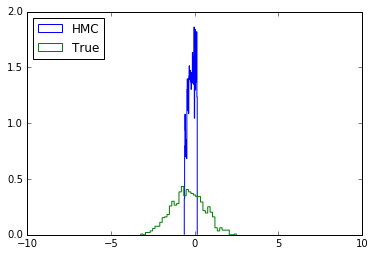

In [101]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.hist(results[round(4*M/5):(M-1),0], 40, histtype='step', normed=True, linewidth=1, label='HMC');
plt.hist(betas, 40, histtype='step', normed=True, linewidth=1, label='True');
#plt.plot(thetas, post.pdf(thetas), c='red', linestyle='--', alpha=0.5, label='True posterior')
plt.xlim([-10,10]);
plt.legend(loc='upper left')
pass

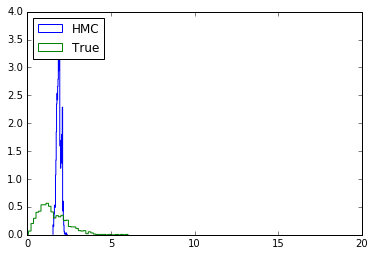

In [102]:
plt.hist(results[round(4*M/5):(M-1),1], 40, histtype='step', normed=True, linewidth=1, label='HMC');
plt.hist(phis, 40, histtype='step', normed=True, linewidth=1, label='True');
#plt.plot(thetas, post.pdf(thetas), c='red', linestyle='--', alpha=0.5, label='True posterior')
plt.xlim([0,20]);
plt.legend(loc='upper left')
pass